# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

# Taxi Demand Prediction for Sweet Lift Taxi Company

Project Overview
Sweet Lift Taxi company operates at airports and faces the challenge of optimizing driver allocation during peak demand periods. To attract more drivers during busy hours and improve service efficiency, the company needs accurate predictions of taxi demand for the upcoming hour.

This project develops a machine learning solution to predict hourly taxi orders using historical data, enabling better resource planning and driver scheduling.

The primary goal is to build a predictive model that can forecast the number of taxi orders for the next hour with high accuracy. Success is measured by achieving a Root Mean Square Error (RMSE) of 48 or lower on the test dataset.

To solve this prediction problem, I will be implementing and comparing multiple modeling approaches. First, I must prepare the data and resample the raw taxi order data to hourly intervals and then perform exploratory data analysis as to understand that data I am working with better. From there, I will train and evaluate different model types. I plan to use a Random Forest Regressors with varying hyperparameters for the baseline and then move to compare ARIMA time series models versus SARIMA models incorporating seasonal patterns. I believe the seasonality will play a large effect in the data. From there I will evaluate the models using a 90/10 train-test split the asses the model performance. I will measure the model performance based on the RMSE metrics.

## Preparation

In [1]:

# Data manipulation and numerical operations
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt

# Machine learning - modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# Time series modeling
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Time series analysis tools
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm



In [2]:
# Load the data
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])
# Display the first 5 rows
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
             datetime  num_orders
0 2018-03-01 00:00:00           9
1 2018-03-01 00:10:00          14
2 2018-03-01 00:20:00          28
3 2018-03-01 00:30:00          20
4 2018-03-01 00:40:00          32


In [3]:

# Set the datetime column as the index
df.set_index('datetime', inplace=True)
# Resample the data by 1 hour, summing the number of orders in each hour
df_hourly = df.resample('H').sum()
# Display the first few rows
print(df_hourly.head())


                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


## Analysis

In [4]:
# Display summary info about the dataset
print("\nSummary info:")
print(df.info())


Summary info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [5]:
# Display basic statistics for numerical columns
print("\nSummary statistics:")
print(df.describe())


Summary statistics:
         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000


The dataset contains 26,496 records of taxi orders collected over time, with two columns: datetime and num_orders. The datetime column is in a proper datetime format, indicating the timestamp of each observation, while num_orders represents the number of taxi orders recorded at that time. The data appears to be recorded at 10-minute intervals, as seen from the first few rows where timestamps increase by 10 minutes. There are no missing values in either column, which suggests the dataset is complete and ready for time series analysis.

In terms of distribution, the number of taxi orders varies significantly, with a minimum of 0 and a maximum of 119 orders in a 10-minute interval. The average number of orders is approximately 14, with a standard deviation of about 9, indicating moderate variability. The median value is 13, and the interquartile range (from 8 to 19) shows that most of the data points cluster around these values. This variability and the presence of high maximum values suggest potential peak periods with increased demand, which will be important to capture in the forecasting model.

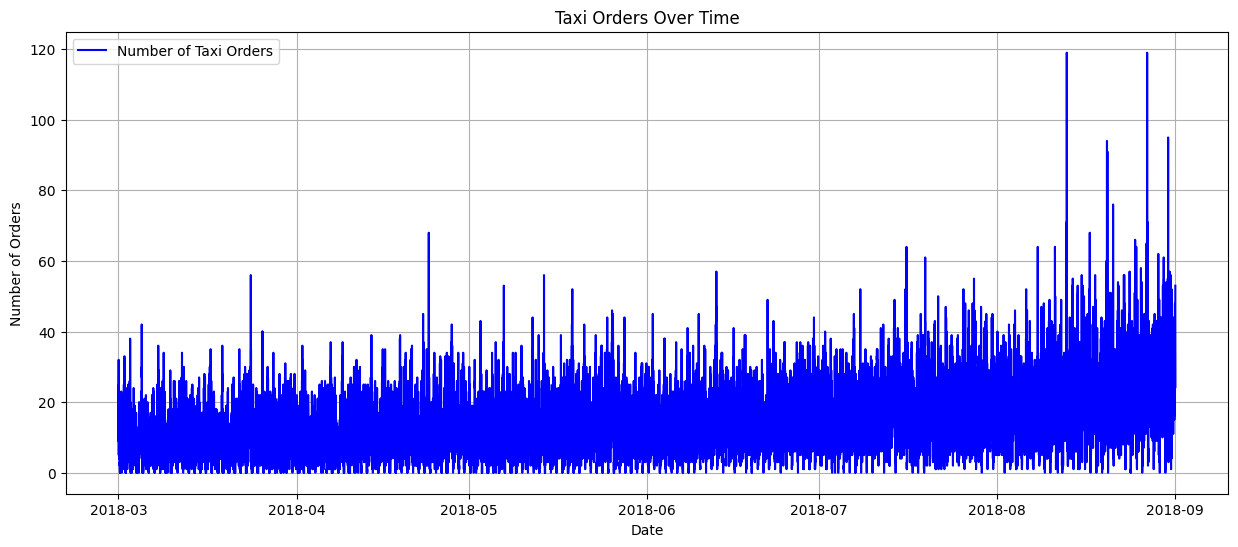

In [6]:
# Plot the time series
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['num_orders'], label='Number of Taxi Orders', color='blue')
plt.title('Taxi Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.legend()
plt.show()

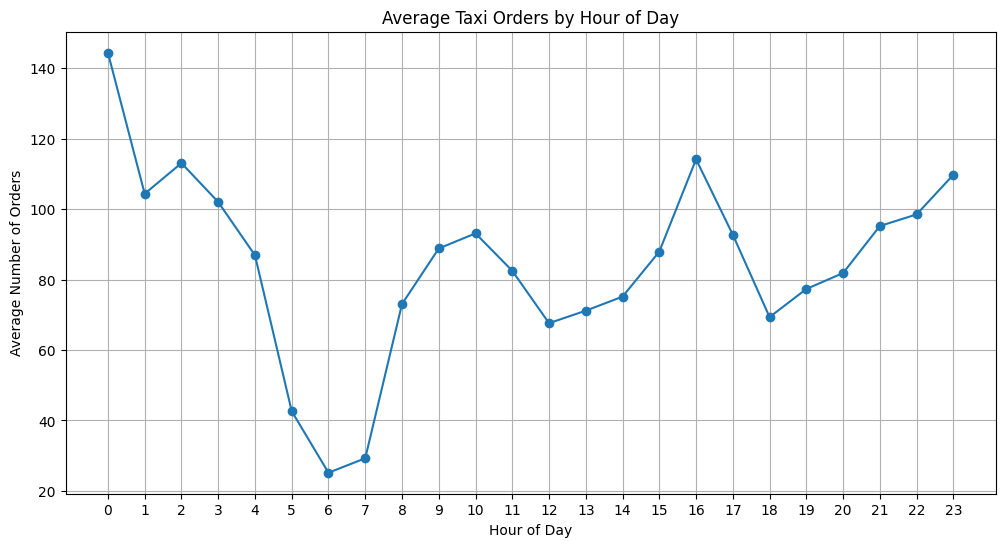

In [7]:
# Extract hour from datetime index
df_hourly['hour'] = df_hourly.index.hour

# Group by hour and calculate mean orders
hourly_pattern = df_hourly.groupby('hour')['num_orders'].mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_pattern.index, hourly_pattern.values, marker='o')
plt.title('Average Taxi Orders by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Orders')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

The graphs show the potential nonstationary time series trend from day to day over time. The times of day seem to have a daily seasonality trend for the spikes, which I will investigate further.

## Training

In [8]:
# Split test sample to 10% 
n = len(df_hourly)
train_size = int(n * 0.9)
train = df_hourly.iloc[:train_size]
test = df_hourly.iloc[train_size:]
print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 3974, Test size: 442


In [9]:

print(df_hourly.head())
print(f"Total hourly data points: {len(df_hourly)}")


                     num_orders  hour
datetime                             
2018-03-01 00:00:00         124     0
2018-03-01 01:00:00          85     1
2018-03-01 02:00:00          71     2
2018-03-01 03:00:00          66     3
2018-03-01 04:00:00          43     4
Total hourly data points: 4416


Now that the training and test samples have been made and the data is split in to hourly increments, I am going to use Random Forest Regressor as my baseline as well as ARIMA and SARIMAX since the time series data has clear seasonality and trends.

## Testing

Before I begin my testing of the models, I will be checking the stationarity of the data with the Augmented Dickey-Fuller test. 

In [10]:

result = adfuller(df['num_orders'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')
    
if result[1] < 0.05:
    print("The data is stationary (reject the null hypothesis).")
else:
    print("The data is non-stationary (fail to reject the null hypothesis).")


ADF Statistic: -12.548885000267546
p-value: 2.2286378815479297e-23
Critical Values:
   1%: -3.430597284562216
   5%: -2.861649292553069
   10%: -2.566828173184574
The data is stationary (reject the null hypothesis).


The data is stationary. I will now use a Random Forest Regressor Test as my baseline for the RMSE and MAE.

In [11]:
# Feature engineering
def create_features(df_hourly):
    df_hourly['hour'] = df_hourly.index.hour
    df_hourly['dayofweek'] = df_hourly.index.dayofweek
    df_hourly['month'] = df_hourly.index.month
    
    # Lag features
    df_hourly['lag_1'] = df_hourly['num_orders'].shift(1)
    df_hourly['lag_24'] = df_hourly['num_orders'].shift(24)
    
    # Rolling mean
    df_hourly['rolling_mean_3'] = df_hourly['num_orders'].shift(1).rolling(window=3).mean()
    
    # Drop rows with NaN values created by lag/rolling calculations
    df_hourly = df_hourly.dropna()
    
    # Return the modified df_hourly, NOT df
    return df_hourly

# Apply feature engineering on train and test sets (make sure these are based on df_hourly)
train_feat = create_features(train.copy())
test_feat = create_features(test.copy())

features = ['hour', 'dayofweek', 'month', 'lag_1', 'lag_24', 'rolling_mean_3']
target = 'num_orders'

# Train Random Forest on train data with features from df_hourly
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(train_feat[features], train_feat[target])

# Predict and evaluate on test data
preds = rf.predict(test_feat[features])
rmse = np.sqrt(mean_squared_error(test_feat[target], preds))
mae = mean_absolute_error(test_feat[target], preds)

print(f"Random Forest RMSE: {rmse:.2f}")
print(f"Random Forest MAE: {mae:.2f}")

Random Forest RMSE: 48.71
Random Forest MAE: 36.40


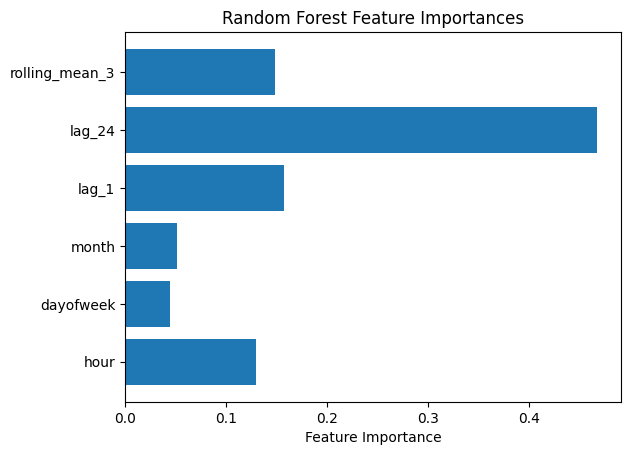

In [12]:

importances = rf.feature_importances_
feature_names = features

plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()

   


The Random Forest feature importance plot shows the relative importance of different features used in the model. Among all features, "lag_24" stands out as the most significant contributor, having the highest feature importance score close to 0.45. This indicates that the value from 24 time units ago plays a crucial role in predicting the target variable. Other notable features include "lag_1," "rolling_mean_3," and "hour," which have moderate importance scores ranging from approximately 0.1 to 0.18. These features represent recent lag values, short-term rolling averages, and the hour of the day, indicating their relevance in capturing temporal patterns.

On the other hand, the features "month" and "dayofweek" exhibit relatively low importance scores, suggesting they are less influential in the model’s predictions. This implies that variations across different months or days of the week have a minor impact compared to recent lag values and hourly information. Overall, the plot highlights that recent historical data points and short-term averages are key drivers in the prediction, while broader time-based features like month and day of the week play a smaller role. 

Because of this, I am going to add more lag features to capture two days ago and one week ago aling with an interaction feature for Monday morning rush hour vs. Sunday quiet morning, etc. 

In [13]:
# Check for NaN values in your features
print("NaN values in train_feat:")
print(train_feat[features].isnull().sum())
print("\nFirst few rows of train_feat:")
print(train_feat[features].head(10))

NaN values in train_feat:
hour              0
dayofweek         0
month             0
lag_1             0
lag_24            0
rolling_mean_3    0
dtype: int64

First few rows of train_feat:
                     hour  dayofweek  month  lag_1  lag_24  rolling_mean_3
datetime                                                                  
2018-03-02 00:00:00     0          4      3   58.0   124.0       79.000000
2018-03-02 01:00:00     1          4      3   90.0    85.0       87.000000
2018-03-02 02:00:00     2          4      3  120.0    71.0       89.333333
2018-03-02 03:00:00     3          4      3   75.0    66.0       95.000000
2018-03-02 04:00:00     4          4      3   64.0    43.0       86.333333
2018-03-02 05:00:00     5          4      3   20.0     6.0       53.000000
2018-03-02 06:00:00     6          4      3   11.0    12.0       31.666667
2018-03-02 07:00:00     7          4      3   11.0    15.0       14.000000
2018-03-02 08:00:00     8          4      3    7.0    34.0  

In [14]:
# Feature engineering
def create_features(df_hourly):
    # First, create time-based features from the datetime index
    df_hourly['hour'] = df_hourly.index.hour
    df_hourly['day_of_week'] = df_hourly.index.dayofweek  # 0=Monday, 6=Sunday
    df_hourly['month'] = df_hourly.index.month
    
    # Lag features
    df_hourly['lag_1'] = df_hourly['num_orders'].shift(1)
    df_hourly['lag_24'] = df_hourly['num_orders'].shift(24)
    df_hourly['lag_48'] = df_hourly['num_orders'].shift(48)
    df_hourly['lag_168'] = df_hourly['num_orders'].shift(168)
    
    # Interaction features (now these columns exist!)
    df_hourly['day_hour_interaction'] = df_hourly['day_of_week'] * 100 + df_hourly['hour']
    
    # Rolling mean
    df_hourly['rolling_mean_3'] = df_hourly['num_orders'].shift(1).rolling(window=3).mean()
    
    return df_hourly

# Apply feature engineering on train and test sets (make sure these are based on df_hourly)
train_feat = create_features(train.copy())
test_feat = create_features(test.copy())

features = ['hour', 'day_of_week', 'month', 'lag_1', 'lag_24', 'rolling_mean_3']
target = 'num_orders'

# Fill NaN values before training the model
train_feat[features] = train_feat[features].fillna(train_feat['num_orders'].mean())
test_feat[features] = test_feat[features].fillna(train_feat['num_orders'].mean())

# Train Random Forest on train data with features from df_hourly
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(train_feat[features], train_feat[target])


# Predict and evaluate on test data
preds = rf.predict(test_feat[features])
rmse = np.sqrt(mean_squared_error(test_feat[target], preds))
mae = mean_absolute_error(test_feat[target], preds)


print(f"Random Forest RMSE: {rmse:.2f}")

print(f"Random Forest MAE: {mae:.2f}")

Random Forest RMSE: 48.82
Random Forest MAE: 36.48


I now have two Random Regressor Models that show a solid baseline with am RMSE between 48 and 49 and a MAE between 36 and 37. Now I will proceed with using SARIMAX. I will start with an ARIMA model. First, I need to examine the ACF and PACF plots to determine the q and p parameter respectively.  

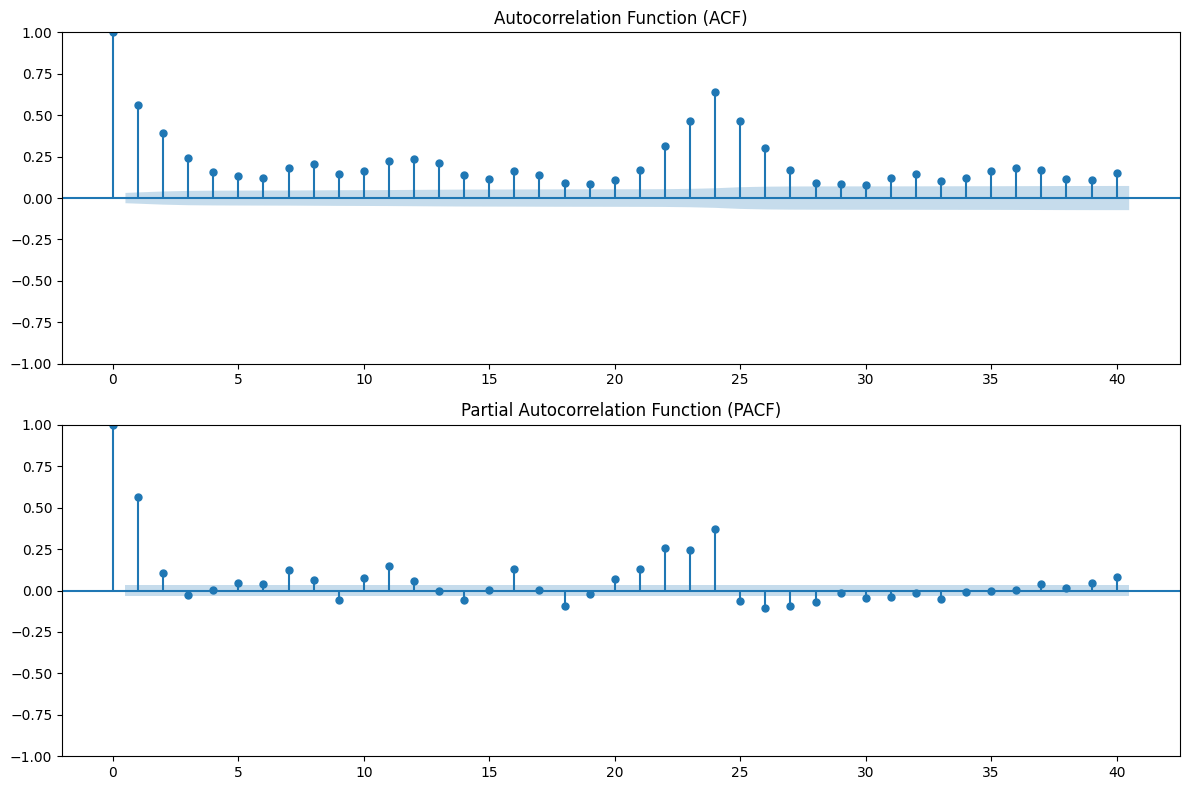

In [15]:
# Create ACF and PACF plots
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(train['num_orders'], ax=axes[0], lags=40)
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot  
plot_pacf(train['num_orders'], ax=axes[1], lags=40)
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


p (AR order) ≈ 1 (PACF cuts off sharply after lag 1)
q (MA order) ≈ 1 or 2 (ACF tails off gradually without sharp cutoff)
This suggests that a preliminary ARIMA model could be ARIMA(1, d, 1) or ARIMA(1, d, 2), where d is the differencing order which is 0 since the data is stationary. 


In [16]:
# Try a simple ARIMA model with manually specified parameters
model = ARIMA(train['num_orders'], order=(1,1,1))
fitted_model = model.fit()

Predictions shape: (442,)
First few predictions: 2018-08-13 14:00:00    115.632745
2018-08-13 15:00:00    114.125268
2018-08-13 16:00:00    113.450390
2018-08-13 17:00:00    113.148256
2018-08-13 18:00:00    113.012994
Freq: H, Name: predicted_mean, dtype: float64
ARIMA RMSE: 64.33


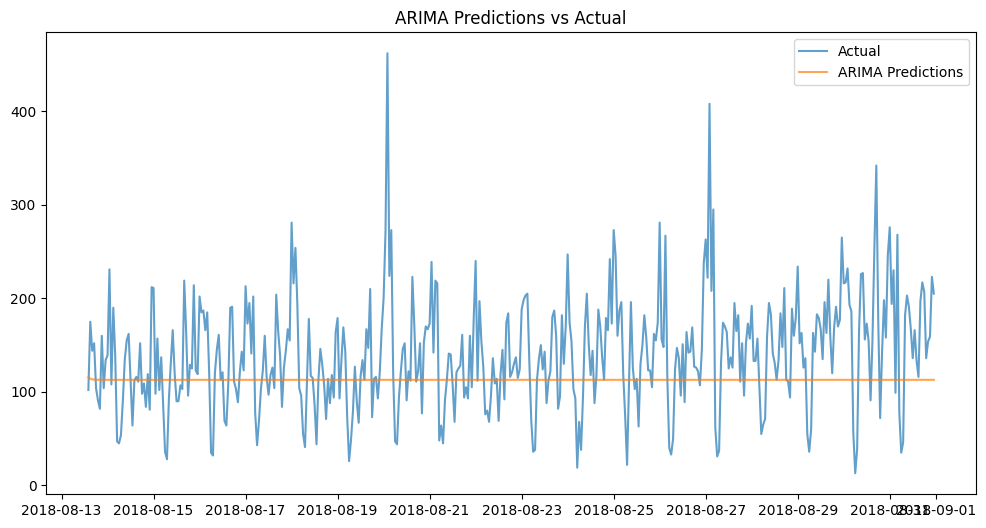

In [17]:
# Make predictions on the test set
predictions = fitted_model.forecast(steps=len(test))
print(f"Predictions shape: {predictions.shape}")
print(f"First few predictions: {predictions[:5]}")

# Calculate RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test['num_orders'], predictions))
print(f"ARIMA RMSE: {rmse:.2f}")

# Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test.index, test['num_orders'], label='Actual', alpha=0.7)
plt.plot(test.index, predictions, label='ARIMA Predictions', alpha=0.7)
plt.legend()
plt.title('ARIMA Predictions vs Actual')
plt.show()

My ARIMA has a baseline RMSE of 64.33. I will now experiment with the parameters to get the RMSE under 48.

In [18]:
# Test different ARIMA parameters
arima_params = [(2,1,1), (1,1,2), (2,1,2), (3,1,1)]

for params in arima_params:
    try:
        model = ARIMA(train['num_orders'], order=params)
        fitted_model = model.fit()
        predictions = fitted_model.forecast(steps=len(test))
        rmse = np.sqrt(mean_squared_error(test['num_orders'], predictions))
        print(f"ARIMA{params} RMSE: {rmse:.2f}")
    except:
        print(f"ARIMA{params} failed to converge")

/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 1) RMSE: 64.43
ARIMA(1, 1, 2) RMSE: 64.40
ARIMA(2, 1, 2) RMSE: 64.27
ARIMA(3, 1, 1) RMSE: 64.17


I believe because the data is so strongly connected to hourly seasonality, that it would be very difficult to get the ARIMA under a 48 RMSE. I will now add in seasonality with SARIMA since there is a clear seasonality correlating to the hour of the day (24):

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Try SARIMA with daily seasonality (s=24 for hourly data)
try:
    # SARIMA(1,1,1)(1,1,1,24) - basic seasonal model
    model = SARIMAX(train['num_orders'], 
                    order=(1,1,1), 
                    seasonal_order=(1,1,1,24))
    fitted_model = model.fit()
    predictions = fitted_model.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test['num_orders'], predictions))
    print(f"SARIMA(1,1,1)(1,1,1,24) RMSE: {rmse:.2f}")
except Exception as e:
    print(f"Error: {e}")

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.65123D+00    |proj g|=  7.64820D-02

At iterate    5    f=  4.58621D+00    |proj g|=  3.57876D-02

At iterate   10    f=  4.49436D+00    |proj g|=  1.45489D-02

At iterate   15    f=  4.49187D+00    |proj g|=  1.07786D-03

At iterate   20    f=  4.48911D+00    |proj g|=  3.11534D-02

At iterate   25    f=  4.48790D+00    |proj g|=  1.04718D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     39      1     0     0   

The SARIMA proves that the seasonality is a large factor and created a massive improvement in the model. I have achieved an RMSE below 48 (44.46) but I am curious to see if there are any exogenous variables that might influence the tax demand, such as weather, holidays, airport schedules and volume, etc. For further analysis, I would recommend gathering ariport flight schedules and daily volume by hour, as well as input the holidays and weather each day into the schedule. I would then analyze any correlations between these parameters and the volume of taxi rides before performing a SARIMAX model on the data. 

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48